In [234]:
import string
import joblib
from os import path

import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils import ls, cat
from pathlib import Path

from time import time

from scipy.spatial.distance import cosine

tqdm.pandas()

In [11]:
#Dmitry
# DATA_DIR = '../../data'
# OUTPUT_DIR = '../../data'

#Anton
DATA_DIR = Path('D:/data/lenta')
OUTPUT_DIR = Path('D:/data/lenta')

#Dmitry
# TRAIN_PATH = f'{DATA_DIR}/lenta-ru-news.csv'

#Anton
TRAIN_PATH = Path('D:/data/lenta/lenta-ru-news.csv/lenta-ru-news.csv')
NUM_ROWS = 5000

TRAIN_LEMMAS_PATH = OUTPUT_DIR / 'train_lemmas.csv'
TRAIN_LEMMAS_PATH_ALL = OUTPUT_DIR / 'train_lemmas_all.csv'


ls(DATA_DIR)

DIR      D:\data\lenta\lenta-ru-news.csv
611.9 MB D:\data\lenta\lenta-ru-news.csv.zip
  7.8 MB D:\data\lenta\train_lemmas.csv


In [12]:
df_train = pd.read_csv(TRAIN_PATH, nrows=NUM_ROWS)
# df_train = pd.read_csv(TRAIN_PATH)

display(df_train.head(3))
display(df_train.shape)

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17


(5000, 6)

## Features

In [13]:
text_cols = ['title', 'text']
all_colls = ['title', 'text', 'date']
text_cols, all_colls

(['title', 'text'], ['title', 'text', 'date'])

In [14]:
df_train[all_colls].head()

,title,text,date
0,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,1914/09/16
1,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",1914/09/16
2,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",1914/09/17
3,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,1914/09/17
4,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",1914/09/18


## Tokenized Text

In [15]:
# !pip install spacy
# python -m spacy download ru_core_news_md

In [16]:
import spacy

nlp = spacy.load('ru_core_news_md', disable=['tagger', 'attribute_ruler', 'senter', 'parser', 'ner'])

In [17]:
train_tokens = df_train[text_cols].fillna('') \
    .progress_applymap(nlp)


train_tokens

100%|██████████| 10000/10000 [03:47<00:00, 44.05it/s]


,title,text
0,"(1914, ., Русские, войска, вступили, в, , пре...","(Бои, у, Сопоцкина, и, Друскеник, закончились,..."
1,"(1914, ., Празднование, столетия, М.Ю., Лермон...","(Министерство, народного, просвещения, ,, в, в..."
2,"(1914, ., Das, ist, Nesteroff, !)","(Штабс, -, капитан, П., Н., Нестеров, на, днях..."
3,"(1914, ., Бульдог, -, гонец, под, Льежем)","(Фотограф, -, корреспондент, Daily, Mirror, ра..."
4,"(1914, ., Под, Люблином, пойман, швабский, зверь)","(Лица, ,, приехавшие, в, Варшаву, из, Люблина,..."
...,...,...
4995,"(Путин, наградил, выдающихся, российских, женщин)","(В, преддверии, Международного, женского, дня,..."
4996,"(Лига, чемпионов, :, "", Реал, "", жаждет, реванша)","(В, среду, в, Мюнхене, в, матче, Лиги, чемпион..."
4997,"(Засада, у, , станицы, Ассиновская, :, убиты,...","(Два, сотрудника, милиции, погибли, и, два, по..."
4998,"(Андрея, Бабицкого, не, , пускают, в, , Европу)","(Следователи, МВД, России, не, позволили, корр..."


In [18]:
def is_alphanum(token):
    return not token.is_punct \
        and not token.is_currency \
        and not token.is_digit \
        and not token.is_punct \
        and not token.is_oov \
        and not token.is_space \
        and not token.is_stop \
        and not token.like_num \
        and not token.pos_ == "PROPN"

df_text = train_tokens \
    .progress_applymap(lambda x: ' '.join(t.lemma_ for t in x if is_alphanum(t)))

df_output_train = pd.concat([df_text, df_train['date']], axis=1)

df_output_train.to_csv(TRAIN_LEMMAS_PATH)

100%|██████████| 10000/10000 [00:00<00:00, 10366.18it/s]


In [19]:
ls(OUTPUT_DIR, path.basename(TRAIN_LEMMAS_PATH))

  7.8 MB D:\data\lenta/train_lemmas.csv


In [42]:
df = pd.read_csv(TRAIN_LEMMAS_PATH, index_col=[0])
df['date'] = df['date'].astype('datetime64')
df

,title,text,date
0,войско вступить предел,закончиться отступление германец приблизиться ...,1914-09-16
1,столетие отложить,народный просвещение вид происходить чрезвычай...,1914-09-16
2,ist,капитан день увидеть район лететь расположение...,1914-09-17
3,гонец,корреспондент рассказывать случай порадует дру...,1914-09-17
4,поймать швабский зверь,приехать передавать доставить швабский зверь в...,1914-09-18
...,...,...,...
4995,наградить выдающийся российский женщина,преддверие женский день исполнять обязанность ...,2000-03-07
4996,чемпион жаждать реванш,среда матч чемпион принимать мадридский встреч...,2000-03-07
4997,станица убить милиционер,сотрудник милиция погибнуть получить ранение р...,2000-03-07
4998,пускать,позволить корреспондент радио поехать весенний...,2000-03-07


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_features = 1000

data_samples = df.title.fillna('')
data_samples

0                                  войско вступить предел
1                                       столетие отложить
2                                                     ist
3                                                   гонец
4                                  поймать швабский зверь
                              ...                        
4995              наградить выдающийся российский женщина
4996                               чемпион жаждать реванш
4997                             станица убить милиционер
4998                                              пускать
4999    опровергнуть информация захват боевик ряд чече...
Name: title, Length: 5000, dtype: object

In [157]:

# Use tf-idf features for NMF.
print("Extracting tf-idf features")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features)

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features)

t0 = time()

tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

Extracting tf-idf features
done in 0.033s.
Extracting tf features for
done in 0.028s.



In [23]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 7.582s.


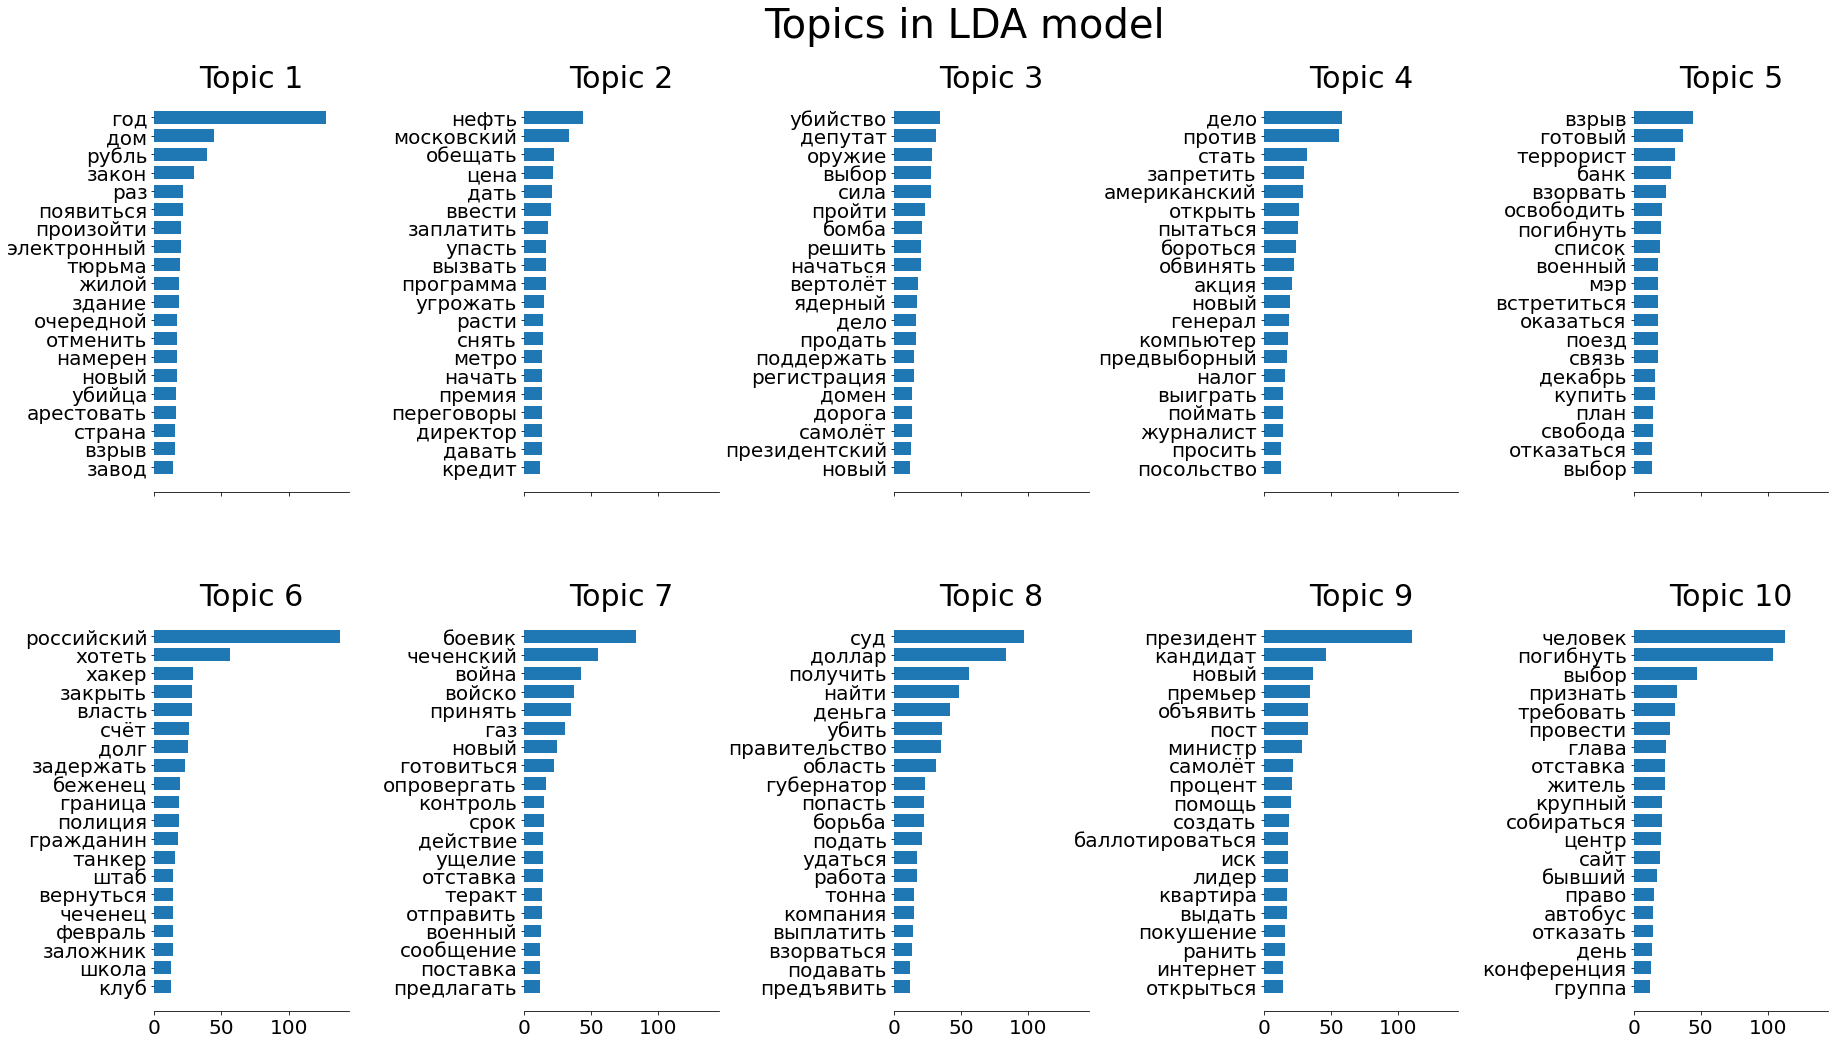

In [158]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)


print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)

t0 = time()
doc_topics = lda.fit_transform(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [95]:
df_train = pd.read_csv(TRAIN_PATH, nrows=NUM_ROWS)

In [96]:
df_train

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18
...,...,...,...,...,...,...
4995,https://lenta.ru/news/2000/03/07/zhenschiny/,Путин наградил выдающихся российских женщин,В преддверии Международного женского дня испол...,Россия,Все,2000/03/07
4996,https://lenta.ru/news/2000/03/07/real/,"Лига чемпионов: ""Реал"" жаждет реванша","В среду в Мюнхене в матче Лиги чемпионов ""Бава...",Спорт,Все,2000/03/07
4997,https://lenta.ru/news/2000/03/07/zasada/,Засада у станицы Ассиновская: убиты два милици...,Два сотрудника милиции погибли и два получили ...,Россия,Все,2000/03/07
4998,https://lenta.ru/news/2000/03/07/babitsky/,Андрея Бабицкого не пускают в Европу,Следователи МВД России не позволили корреспонд...,Россия,Все,2000/03/07


In [97]:
df_train['date'] = df_train["date"].astype("datetime64")

In [98]:
print('Количество строк с датой в 1914 году:')
print(df_train[df_train.date < '1950-01-01'].date.count())

Количество строк с датой в 1914 году:
5


In [99]:
df.drop(df[df.date < '1950-01-01'].index, inplace=True)
df

,title,text,date,topic
5,сомневаться надёжность,известный агентство экипаж последний экспедици...,1999-08-31,[]
6,центр пострадать человек,зал игровой автомат ярус подземный комплекс ря...,1999-08-31,[9]
7,доллар,принять решение разморозить кредит сумма долла...,1999-08-31,[7]
8,отмечать смерть,отмечать сегодня скорбный дата день смерть при...,1999-08-31,[2]
9,of деньга иметь отношение,понедельник директор департамент внешний связь...,1999-08-31,"[3, 7]"
...,...,...,...,...
4995,наградить выдающийся российский женщина,преддверие женский день исполнять обязанность ...,2000-03-07,[4]
4996,чемпион жаждать реванш,среда матч чемпион принимать мадридский встреч...,2000-03-07,[0]
4997,станица убить милиционер,сотрудник милиция погибнуть получить ранение р...,2000-03-07,[7]
4998,пускать,позволить корреспондент радио поехать весенний...,2000-03-07,[5]


In [100]:
topics_treshold = 0.3

df['topic'] = pd.DataFrame(doc_topics).apply(list, axis=1) \
    .apply(lambda x: [i for i, w in enumerate(x) if w > topics_treshold])

In [101]:
t = 1

df_topic0 = df[df['topic'].apply(lambda x: t in x)].groupby(by='date').count()

In [102]:
df_topic0

,title,text,topic
date,,,
1999-09-01,3,3,3
1999-09-02,3,3,3
1999-09-03,5,5,5
1999-09-06,1,1,1
1999-09-08,1,1,1
...,...,...,...
2000-03-02,6,6,6
2000-03-03,3,3,3
2000-03-04,3,3,3


<AxesSubplot:title={'center':'topic 0'}, xlabel='date'>

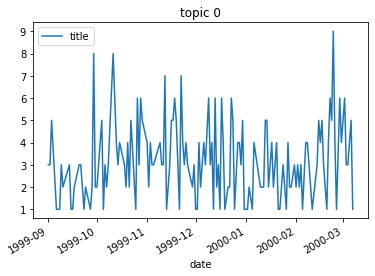

In [103]:
df_topic0.plot(y='title',title='topic 0')

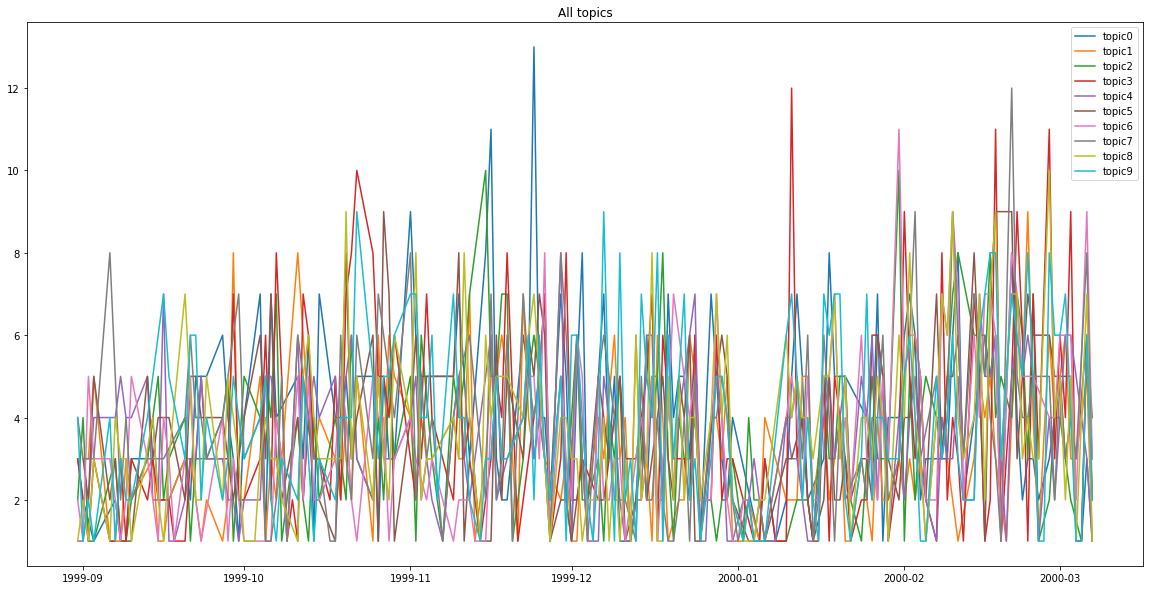

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

for i in range(0, 10):
    x = df[df['topic'].apply(lambda x: i in x)].groupby(by='date').count().index.to_numpy()
    y = df[df['topic'].apply(lambda x: i in x)].groupby(by='date').count().topic.to_numpy()
    plt.plot(x, y, label = 'topic' + str(i))


plt.legend()
plt.title('All topics')
plt.show()

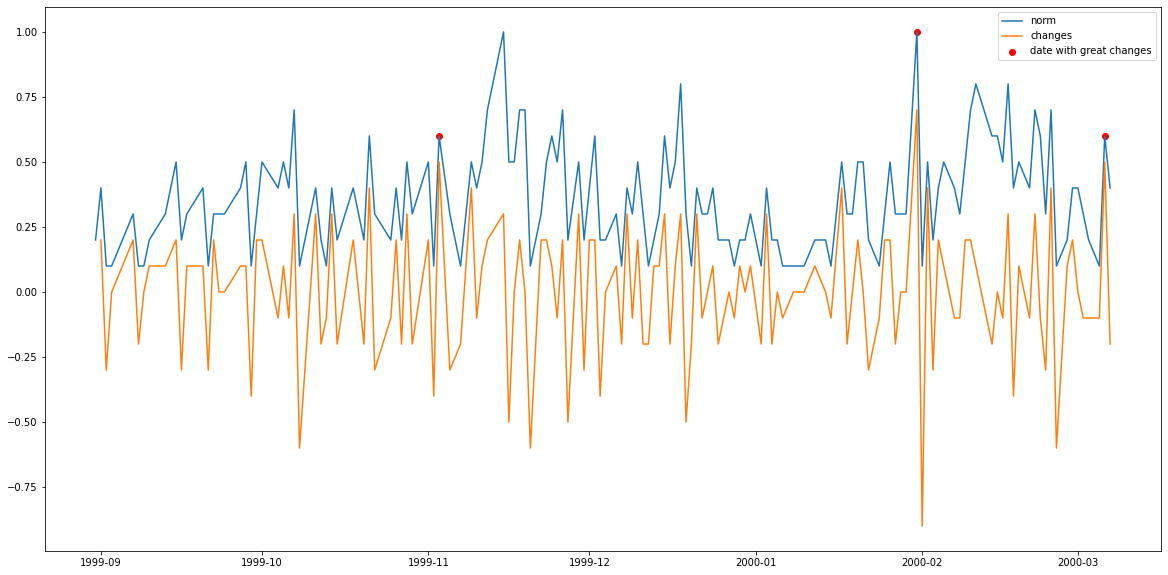

In [105]:
topic_num = 2
date_list = df[df['topic'].apply(lambda x: topic_num in x)].groupby(by='date').count().index.to_numpy()
count_list = df[df['topic'].apply(lambda x: topic_num in x)].groupby(by='date').count().topic.to_numpy()

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
# ax = plt.gca()

def plot_changes_(ax, date_list, count_list, thresh=.4):

    thresh = 0.4
    topic_num = 0
    # date_list[:10], count_list[:120]

    norm_count = [float(i) / max(count_list) for i in count_list]
    ax.plot(date_list, norm_count, label='norm')

    changes = []
    for i in range(1, len(norm_count)):
        changes.append(norm_count[i] - norm_count[i-1])
        
    ax.plot(date_list[1:], changes, label='changes')
    ind_great_changes = [i+1 for i,v in enumerate(changes) if v >thresh]
    ax.scatter(np.array(date_list)[ind_great_changes], np.array(norm_count)[ind_great_changes], c='r', label='date with great changes')

    # ax.title('Даты с изменением в процентных изменения максимума более чем на {}%'.format(thresh *100))
    ax.legend()
    
    
plot_changes_(ax, date_list, count_list)

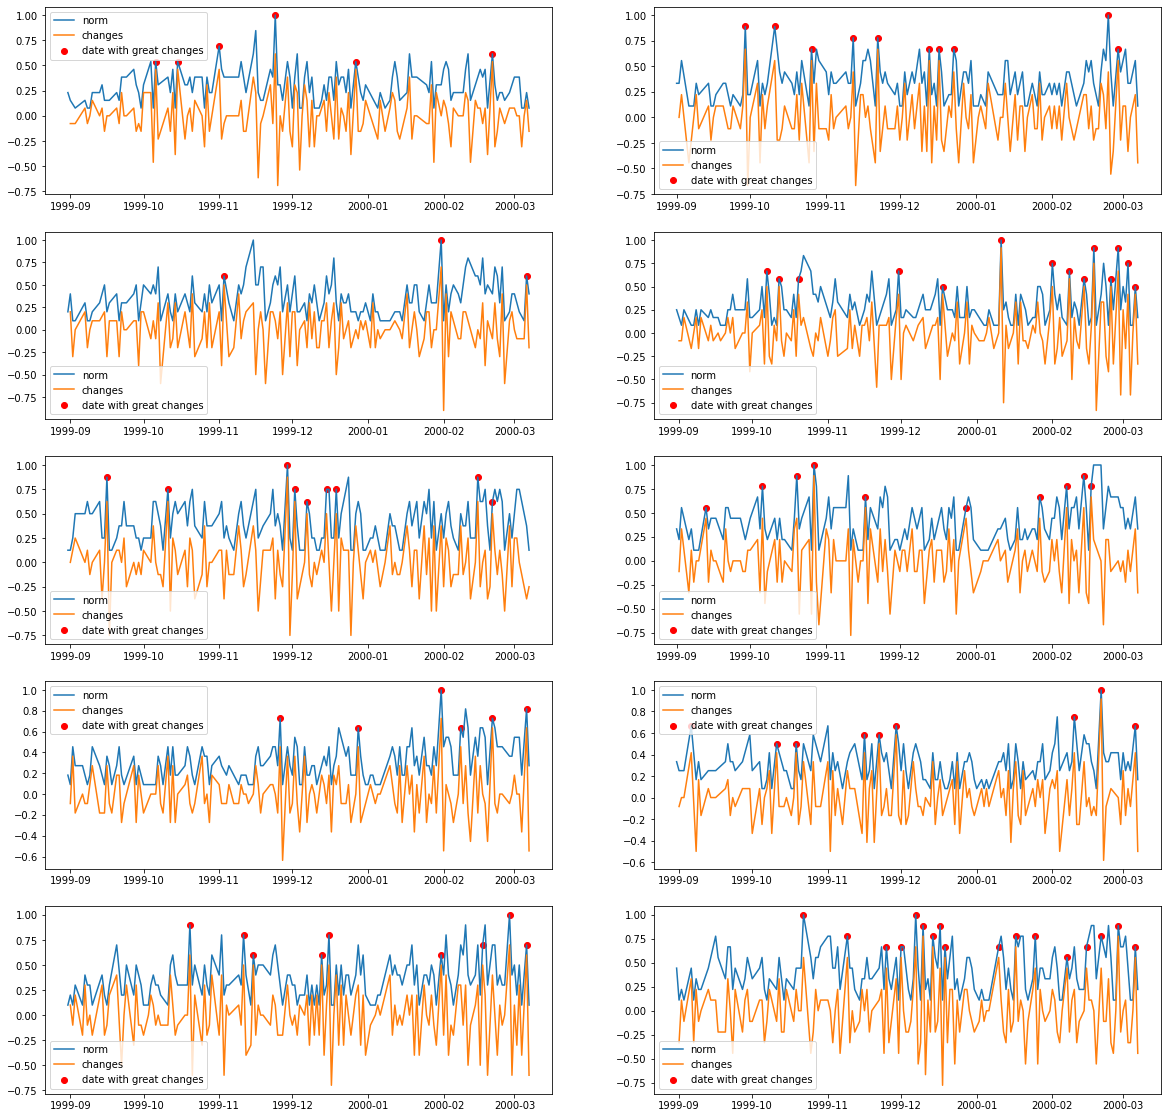

In [106]:
fig, axes = plt.subplots(5, 2)

fig.set_size_inches(20, 20)

ax = axes.flatten()

for i in range(0, 10):
    topic_num = i
    date_list = df[df['topic'].apply(lambda x: topic_num in x)].groupby(by='date').count().index.to_numpy()
    count_list = df[df['topic'].apply(lambda x: topic_num in x)].groupby(by='date').count().topic.to_numpy()
    plot_changes_(ax[i], date_list, count_list)

In [107]:
topic_num = 0
thresh = 0.4

date_list = df[df['topic'].apply(lambda x: topic_num in x)].groupby(by='date').count().index.to_numpy()
count_list = df[df['topic'].apply(lambda x: topic_num in x)].groupby(by='date').count().topic.to_numpy()
norm_count = [float(i) / max(count_list) for i in count_list]
changes = []

for i in range(1, len(norm_count)):
    changes.append(norm_count[i] - norm_count[i-1])

ind_great_changes = [i+1 for i,v in enumerate(changes) if v >thresh]
date_great_changes = np.array(date_list)[ind_great_changes]

for date in date_great_changes:
    print(date)
    ind = df[(df.date == date) & (df['topic'].apply(lambda x: topic_num in x))].index
    # print(ind)
    print(df_train.iloc[ind].title)

1999-10-06T00:00:00.000000000
697     Полмиллиарда пользователей Интернета в 2003 году
701    Журналистка арестована на основании записей пр...
708     Краевую думу Приморья оставят без финансирования
710             На финской АЭС произошла утечка водорода
713           В Татарстане произошли массовые беспорядки
720     Туркменистан хочет протянуть газопровод в Турцию
721                    Два табачных гиганта объединяются
Name: title, dtype: object
1999-10-15T00:00:00.000000000
925    Глава Федеральной комиссии по рынку ценных бум...
926                    Выпущены золотые деньги 2000 года
927    Представители Минобороны воровали приборы с Ра...
929    Судебный комитет Конгресса одобрил закон об эл...
938    Столкновения в Косово: пострадали 100 албанцев...
950    Более 150 палестинцев освобождены из израильск...
952                           Доходы Sun возросли на 25%
Name: title, dtype: object
1999-11-01T00:00:00.000000000
1330               С 1 ноября повышены минимальные пенсии


In [108]:
df_train

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914-09-16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914-09-16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914-09-17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914-09-17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914-09-18
...,...,...,...,...,...,...
4995,https://lenta.ru/news/2000/03/07/zhenschiny/,Путин наградил выдающихся российских женщин,В преддверии Международного женского дня испол...,Россия,Все,2000-03-07
4996,https://lenta.ru/news/2000/03/07/real/,"Лига чемпионов: ""Реал"" жаждет реванша","В среду в Мюнхене в матче Лиги чемпионов ""Бава...",Спорт,Все,2000-03-07
4997,https://lenta.ru/news/2000/03/07/zasada/,Засада у станицы Ассиновская: убиты два милици...,Два сотрудника милиции погибли и два получили ...,Россия,Все,2000-03-07
4998,https://lenta.ru/news/2000/03/07/babitsky/,Андрея Бабицкого не пускают в Европу,Следователи МВД России не позволили корреспонд...,Россия,Все,2000-03-07


In [86]:
from pathlib import Path

def read_role(path):
    with open(path, 'r', encoding='utf8') as file:
        TEXT = file.read()
        
    return TEXT

ceo_file = Path('../data/roles/ceo.txt')
acc_path = Path('../data/roles/accauntant.txt')

DATA_ACCAUNTANT = read_role(acc_path).split(sep='\n')
DATA_CEO = read_role(ceo_file).split(sep='\n\n***\n')

In [87]:
from role import RoleWordsIDF

acc_features = RoleWordsIDF().fit(DATA_ACCAUNTANT).get_feature_names()
ceo_features = RoleWordsIDF().fit(DATA_CEO).get_feature_names()

Признаки с наименьшими значениями tfidf
['информация' 'деятельность' 'сопоставимость' 'подаваться' 'анализ'
 'пользователь' 'последовательность' 'ведение' 'процесс' 'управление'
 'завершённость' 'значимость' 'измерение' 'исключение'
 'конфиденциальность' 'непрерывность' 'единство' 'объективность'
 'правдивость' 'осмотрительность']
Признаки с наибольшими значениями tfidf
['обозримый' 'найти' 'нормативный' 'несоблюдение' 'оговариваться'
 'неполный' 'недостоверный' 'натуральный' 'нарушение' 'бухгалтерский'
 'учёт' 'принцип' 'предприятие' 'представлять' 'денежный' 'момент'
 'период' 'ожидать' 'операция' 'год']
Признаки с наименьшими значениями tfidf
['компания' 'цель' 'достигнуть' 'любить' 'важный' 'директор' 'мозг'
 'приходить' 'миллион' 'прийти' 'менеджер' 'бизнес' 'больший' 'говорить'
 'работа' 'хороший' 'генеральный' 'жизнь' 'сотрудник' 'деньга']
Признаки с наибольшими значениями tfidf
['минимум' 'косметика' 'язык' 'называть' 'многих' 'набор' 'человек' 'ни'
 'время' 'настроение' 'задач

In [125]:
acc_x = tf_vectorizer.transform([' '.join(acc_features.tolist())])
ceo_x = tf_vectorizer.transform([' '.join(ceo_features.tolist())])

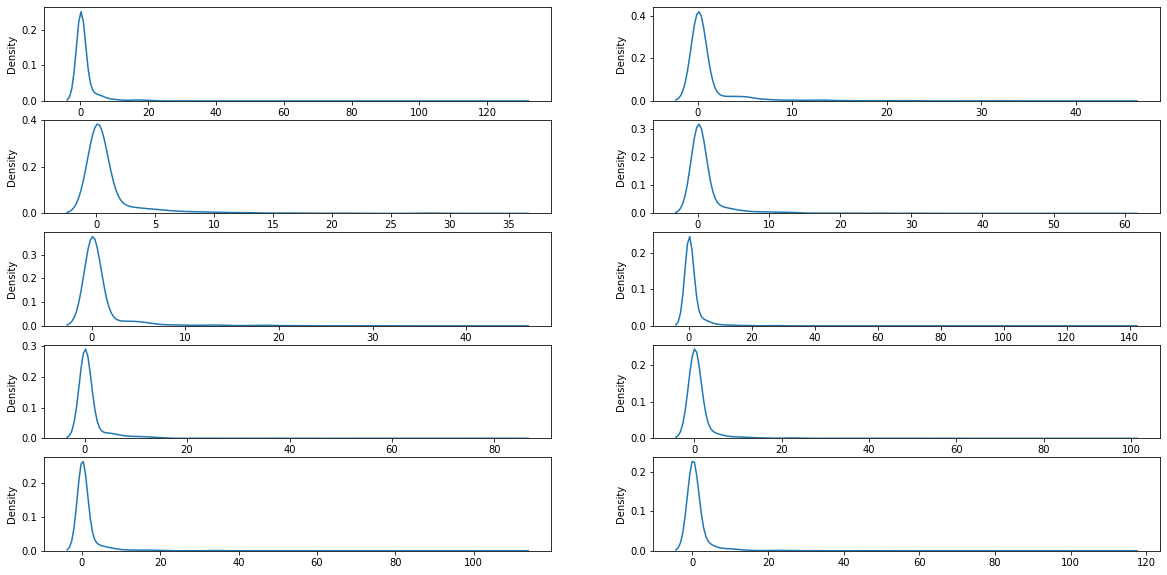

In [176]:
import seaborn as sns

fig, axes =  plt.subplots(5, 2)
fig.set_size_inches(20, 10)
ax = axes.flatten()
lda0 = lda.components_[0]

for i in range(10):
    ldac = lda.components_[i]
    sns.kdeplot(ldac, ax=ax[i])

In [261]:
update_ldca_thresh = 1

def update_ldca(lda_component):
    ldaс_updated = []

    for comp in lda_component:
        ldac_new = []
        for j in comp:
            if j > update_ldca_thresh:
                ldac_new.append(1)
            else:
                ldac_new.append(0)
        ldaс_updated.append(np.array(ldac_new))
        
    return np.array(ldaс_updated)

def best_topics_for_role(role_features, lda_component):
    ldac_upd = update_ldca(lda_component)
    
    cos_list = [cosine(role_features.toarray()[0], i) for i in  ldac_upd]
    return (np.argsort(cos_list), cos_list)


print('List of topics to accounter')
topics, dist = best_topics_for_role(acc_x, lda.components_)
for t in topics:
    print('topic number:', t, 'cos_dist to role: ', dist[t])

print()
print('List of topics to ceo')
topics, dist = best_topics_for_role(ceo_x, lda.components_)
for t in topics:
    print('topic number:', t, 'cos_dist to role: ', dist[t])

List of topics to accounter
topic number: 6 cos_dist to role:  0.8545641503308841
topic number: 0 cos_dist to role:  0.8691495744150575
topic number: 3 cos_dist to role:  0.8937715652160623
topic number: 8 cos_dist to role:  0.89971755788722
topic number: 2 cos_dist to role:  0.9070018890049446
topic number: 7 cos_dist to role:  0.9095851698659183
topic number: 9 cos_dist to role:  0.9256477604355086
topic number: 5 cos_dist to role:  0.938732114825516
topic number: 1 cos_dist to role:  0.9500039057922959
topic number: 4 cos_dist to role:  0.9502904187199039

List of topics to ceo
topic number: 9 cos_dist to role:  0.8720584210702103
topic number: 4 cos_dist to role:  0.8950218681664353
topic number: 6 cos_dist to role:  0.8976214550815097
topic number: 2 cos_dist to role:  0.9018019493938034
topic number: 1 cos_dist to role:  0.9061482683352553
topic number: 0 cos_dist to role:  0.9106800115647048
topic number: 7 cos_dist to role:  0.9151374871304474
topic number: 3 cos_dist to role: 